This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the latest 30 minutes of available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves 6 timesteps of the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 120 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to single file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

<div class="alert alert-warning">

**Note** <br>

The following code is based on [xarray](https://docs.xarray.dev), [xarray-datatree](https://xarray-datatree.readthedocs.io) and [xradar](https://docs.openradarscience.org/projects/xradar). It claims multiple data files and presents them in a ``DataTree``.

</div>

In [1]:
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime

## Download radar volumes of latest 30 minutes from server using `wetterdienst`


`wetterdienst` is a neat package for easy retrieval of data primarily from DWD. For further information have a look at their [documentation](https://wetterdienst.readthedocs.io/).

In [3]:
from wetterdienst.provider.dwd.radar import (
    DwdRadarDataFormat,
    DwdRadarDataSubset,
    DwdRadarParameter,
    DwdRadarValues,
)
from wetterdienst.provider.dwd.radar.sites import DwdRadarSite

In [4]:
elevations = range(10)

end_date = datetime.datetime.utcnow()
start_date = end_date - datetime.timedelta(minutes=30)

results_velocity = []
results_reflectivity = []

for el in elevations:
    # Horizontal Doppler Velocity
    request_velocity = DwdRadarValues(
        parameter=DwdRadarParameter.SWEEP_VOL_VELOCITY_H,
        start_date=start_date,
        end_date=end_date,
        site=DwdRadarSite.ESS,
        elevation=el,
        fmt=DwdRadarDataFormat.HDF5,
        subset=DwdRadarDataSubset.POLARIMETRIC,
    )

    # Horizontal Reflectivity
    request_reflectivity = DwdRadarValues(
        parameter=DwdRadarParameter.SWEEP_VOL_REFLECTIVITY_H,
        start_date=start_date,
        end_date=end_date,
        elevation=el,
        site=DwdRadarSite.ESS,
        fmt=DwdRadarDataFormat.HDF5,
        subset=DwdRadarDataSubset.POLARIMETRIC,
    )

    # Submit requests.
    results_velocity.append(request_velocity.query())
    results_reflectivity.append(request_reflectivity.query())

In [5]:
import wetterdienst

wetterdienst.__version__

'0.65.0'

## Acquire data as memory buffer

In [6]:
%%time
volume_velocity = []
for item1 in results_velocity:
    files = []
    for item2 in item1:
        files.append(item2.data)
    volume_velocity.append(files)

CPU times: user 2.85 s, sys: 95.3 ms, total: 2.94 s
Wall time: 18.2 s


In [7]:
volume_velocity = [v[-6:] for v in volume_velocity]
volume_velocity = np.array(volume_velocity).T.tolist()

In [8]:
%%time
volume_reflectivity = []
for item1 in results_reflectivity:
    files = []
    for item2 in item1:
        files.append(item2.data)
    volume_reflectivity.append(files)

CPU times: user 2.93 s, sys: 95.4 ms, total: 3.02 s
Wall time: 17.9 s


In [9]:
volume_reflectivity = [v[-6:] for v in volume_reflectivity]
volume_reflectivity = np.array(volume_reflectivity).T.tolist()

## Read the data into xarray powered structure

In [10]:
from datatree import DataTree, open_datatree
import xradar


def concat_radar_datatree(objs, dim="volume_time"):
    root_ds = [obj["/"].ds for obj in objs]
    root = xr.concat(root_ds, dim=dim)
    dtree = DataTree(data=root, name="root")
    for grp in objs[0].groups[1:]:
        ngrps = [obj[grp[1:]].ds for obj in objs]
        ngrp = xr.concat(ngrps, dim=dim)
        DataTree(ngrp, name=grp[1:], parent=dtree)
    return dtree

In [11]:
dsl = []
reindex_angle = dict(
    tolerance=1.0, start_angle=0, stop_angle=360, angle_res=1.0, direction=1
)
for r, v in zip(volume_reflectivity, volume_velocity):
    ds0 = [
        xr.open_dataset(r0, engine="odim", group="sweep_0", reindex_angle=reindex_angle)
        for r0 in r
    ]
    ds1 = [
        xr.open_dataset(v0, engine="odim", group="sweep_0", reindex_angle=reindex_angle)
        for v0 in v
    ]
    ds = [xr.merge([r0, v0], compat="override") for r0, v0 in zip(ds0, ds1)]
    ds.insert(0, xr.open_dataset(r[0], group="/"))
    dsl.append(ds)
# this takes some private functions from xradar, take care here
trees = [
    DataTree(data=xradar.io.backends.common._assign_root(ds), name="root") for ds in dsl
]
trees = [
    xradar.io.backends.common._attach_sweep_groups(tree, ds[1:])
    for tree, ds in zip(trees, dsl)
]
vol = concat_radar_datatree(trees, dim="volume_time")
# align sweep_numbers to cover for single sweep single moment layout of DWD
for i, swp in enumerate(vol.groups[1:]):
    vol[swp]["sweep_number"] = i

In [12]:
vol

DataTree('root', parent=None)
│   Dimensions:              (volume_time: 6)
│   Dimensions without coordinates: volume_time
│   Data variables:
│       volume_number        (volume_time) int64 0 0 0 0 0 0
│       platform_type        (volume_time) <U5 'fixed' 'fixed' ... 'fixed' 'fixed'
│       instrument_type      (volume_time) <U5 'radar' 'radar' ... 'radar' 'radar'
│       time_coverage_start  (volume_time) <U20 '2023-11-03T14:11:44Z' ... '2023-...
│       time_coverage_end    (volume_time) <U20 '2023-11-03T14:16:43Z' ... '2023-...
│       longitude            (volume_time) float64 6.967 6.967 6.967 ... 6.967 6.967
│       altitude             (volume_time) float64 185.1 185.1 185.1 ... 185.1 185.1
│       latitude             (volume_time) float64 51.41 51.41 51.41 ... 51.41 51.41
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 5.493 5.493 ... 5.493
│           time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:15...
│           longitude          float64 6.967
│           latitude           float64 51.41
│           altitude           float64 185.1
│       Dimensions without coordinates: volume_time
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
│           sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
│           sweep_number       int64 0
│           prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 5.499 5.499 5.499 5.499 5.499 5.499
│           VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0
├── DataTree('sweep_1')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 4.493 4.493 ... 4.493
│           time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:16...
│           longitude          float64 6.967
│           latitude           float64 51.41
│           altitude           float64 185.1
│       Dimensions without coordinates: volume_time
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
│           sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
│           sweep_number       int64 1
│           prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 4.499 4.499 4.499 4.499 4.499 4.499
│           VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0
├── DataTree('sweep_2')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 3.505 3.505 ... 3.505
│           time               (vo

In [13]:
vol["sweep_9"]

DataTree('sweep_9', parent="root")
    Dimensions:            (range: 240, azimuth: 360, volume_time: 6)
    Coordinates:
      * range              (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
      * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 24.98 24.98 ... 24.99
        time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:13...
        longitude          float64 6.967
        latitude           float64 51.41
        altitude           float64 185.1
    Dimensions without coordinates: volume_time
    Data variables:
        DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
        sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
        sweep_number       int64 9
        prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 25.0 25.0 25.0 25.0 25.0 25.0
        VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0

## Inspect structure
### Root Group

In [14]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              (volume_time: 6)
│   Dimensions without coordinates: volume_time
│   Data variables:
│       volume_number        (volume_time) int64 0 0 0 0 0 0
│       platform_type        (volume_time) <U5 'fixed' 'fixed' ... 'fixed' 'fixed'
│       instrument_type      (volume_time) <U5 'radar' 'radar' ... 'radar' 'radar'
│       time_coverage_start  (volume_time) <U20 '2023-11-03T14:11:44Z' ... '2023-...
│       time_coverage_end    (volume_time) <U20 '2023-11-03T14:16:43Z' ... '2023-...
│       longitude            (volume_time) float64 6.967 6.967 6.967 ... 6.967 6.967
│       altitude             (volume_time) float64 185.1 185.1 185.1 ... 185.1 185.1
│       latitude             (volume_time) float64 51.41 51.41 51.41 ... 51.41 51.41
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 5.493 5.493 ... 5.493
│           time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:15...
│           longitude          float64 6.967
│           latitude           float64 51.41
│           altitude           float64 185.1
│       Dimensions without coordinates: volume_time
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
│           sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
│           sweep_number       int64 0
│           prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 5.499 5.499 5.499 5.499 5.499 5.499
│           VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0
├── DataTree('sweep_1')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 4.493 4.493 ... 4.493
│           time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:16...
│           longitude          float64 6.967
│           latitude           float64 51.41
│           altitude           float64 185.1
│       Dimensions without coordinates: volume_time
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
│           sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
│           sweep_number       int64 1
│           prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 4.499 4.499 4.499 4.499 4.499 4.499
│           VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0
├── DataTree('sweep_2')
│       Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 3.505 3.505 ... 3.505
│           time               (vo

### Sweep Groups

In [15]:
vol["sweep_0"]

DataTree('sweep_0', parent="root")
    Dimensions:            (range: 720, azimuth: 360, volume_time: 6)
    Coordinates:
      * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 5.493 5.493 ... 5.493
        time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:15...
        longitude          float64 6.967
        latitude           float64 51.41
        altitude           float64 185.1
    Dimensions without coordinates: volume_time
    Data variables:
        DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
        sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
        sweep_number       int64 0
        prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 5.499 5.499 5.499 5.499 5.499 5.499
        VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0

## plot sweeps
### DBZH

In [16]:
vol["sweep_0"].isel(volume_time=0)

DataTree('sweep_0', parent=None)
    Dimensions:            (range: 720, azimuth: 360)
    Coordinates:
      * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
        elevation          (azimuth) float64 5.493 5.493 5.493 ... 5.493 5.493 5.493
        time               (azimuth) datetime64[ns] 2023-11-03T14:15:54.482500096...
        longitude          float64 6.967
        latitude           float64 51.41
        altitude           float64 185.1
    Data variables:
        DBZH               (azimuth, range) float32 -64.0 -64.0 ... -64.0 -64.0
        sweep_mode         <U20 'azimuth_surveillance'
        sweep_number       int64 0
        prt_mode           <U7 'not_set'
        follow_mode        <U7 'not_set'
        sweep_fixed_angle  float64 5.499
        VRADH              (azimuth, range) float32 -128.0 -128.0 ... -128.0 -128.0

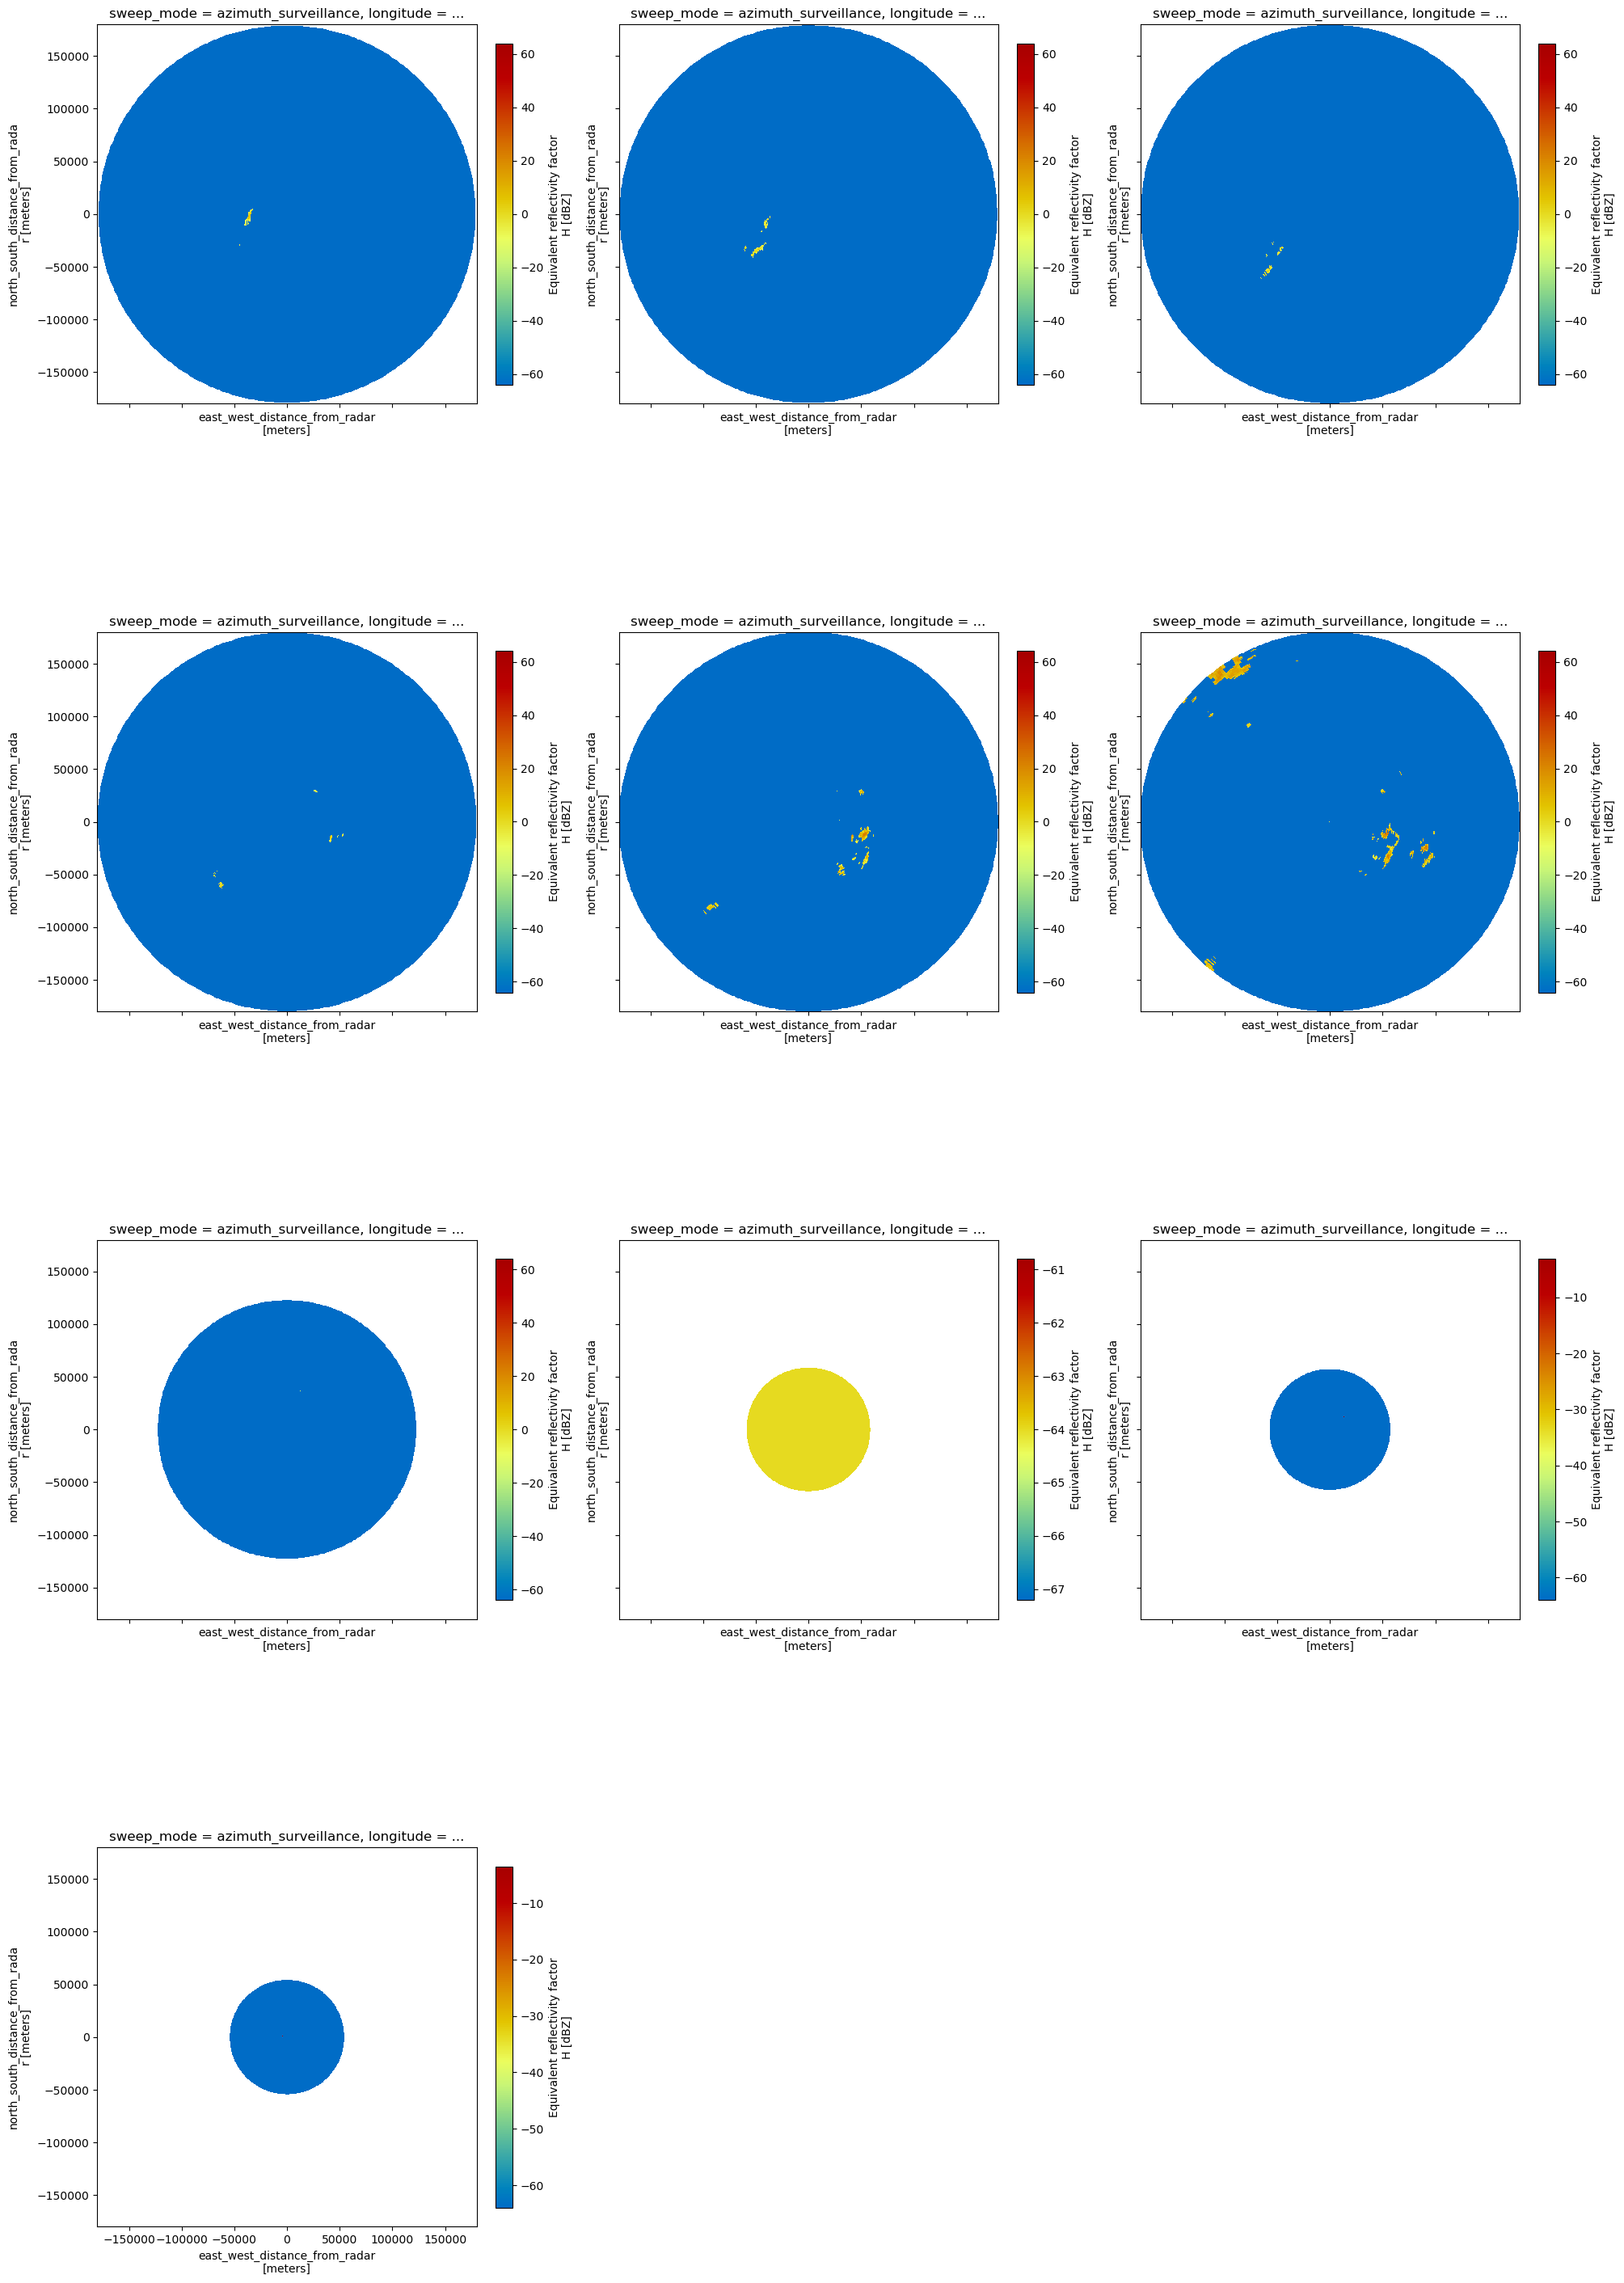

In [17]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.groups[1:]):
    swp = vol[grp].isel(volume_time=0).ds
    swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
    swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=gs.flat[i], fig=fig)
    ax = plt.gca()
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### VRADH

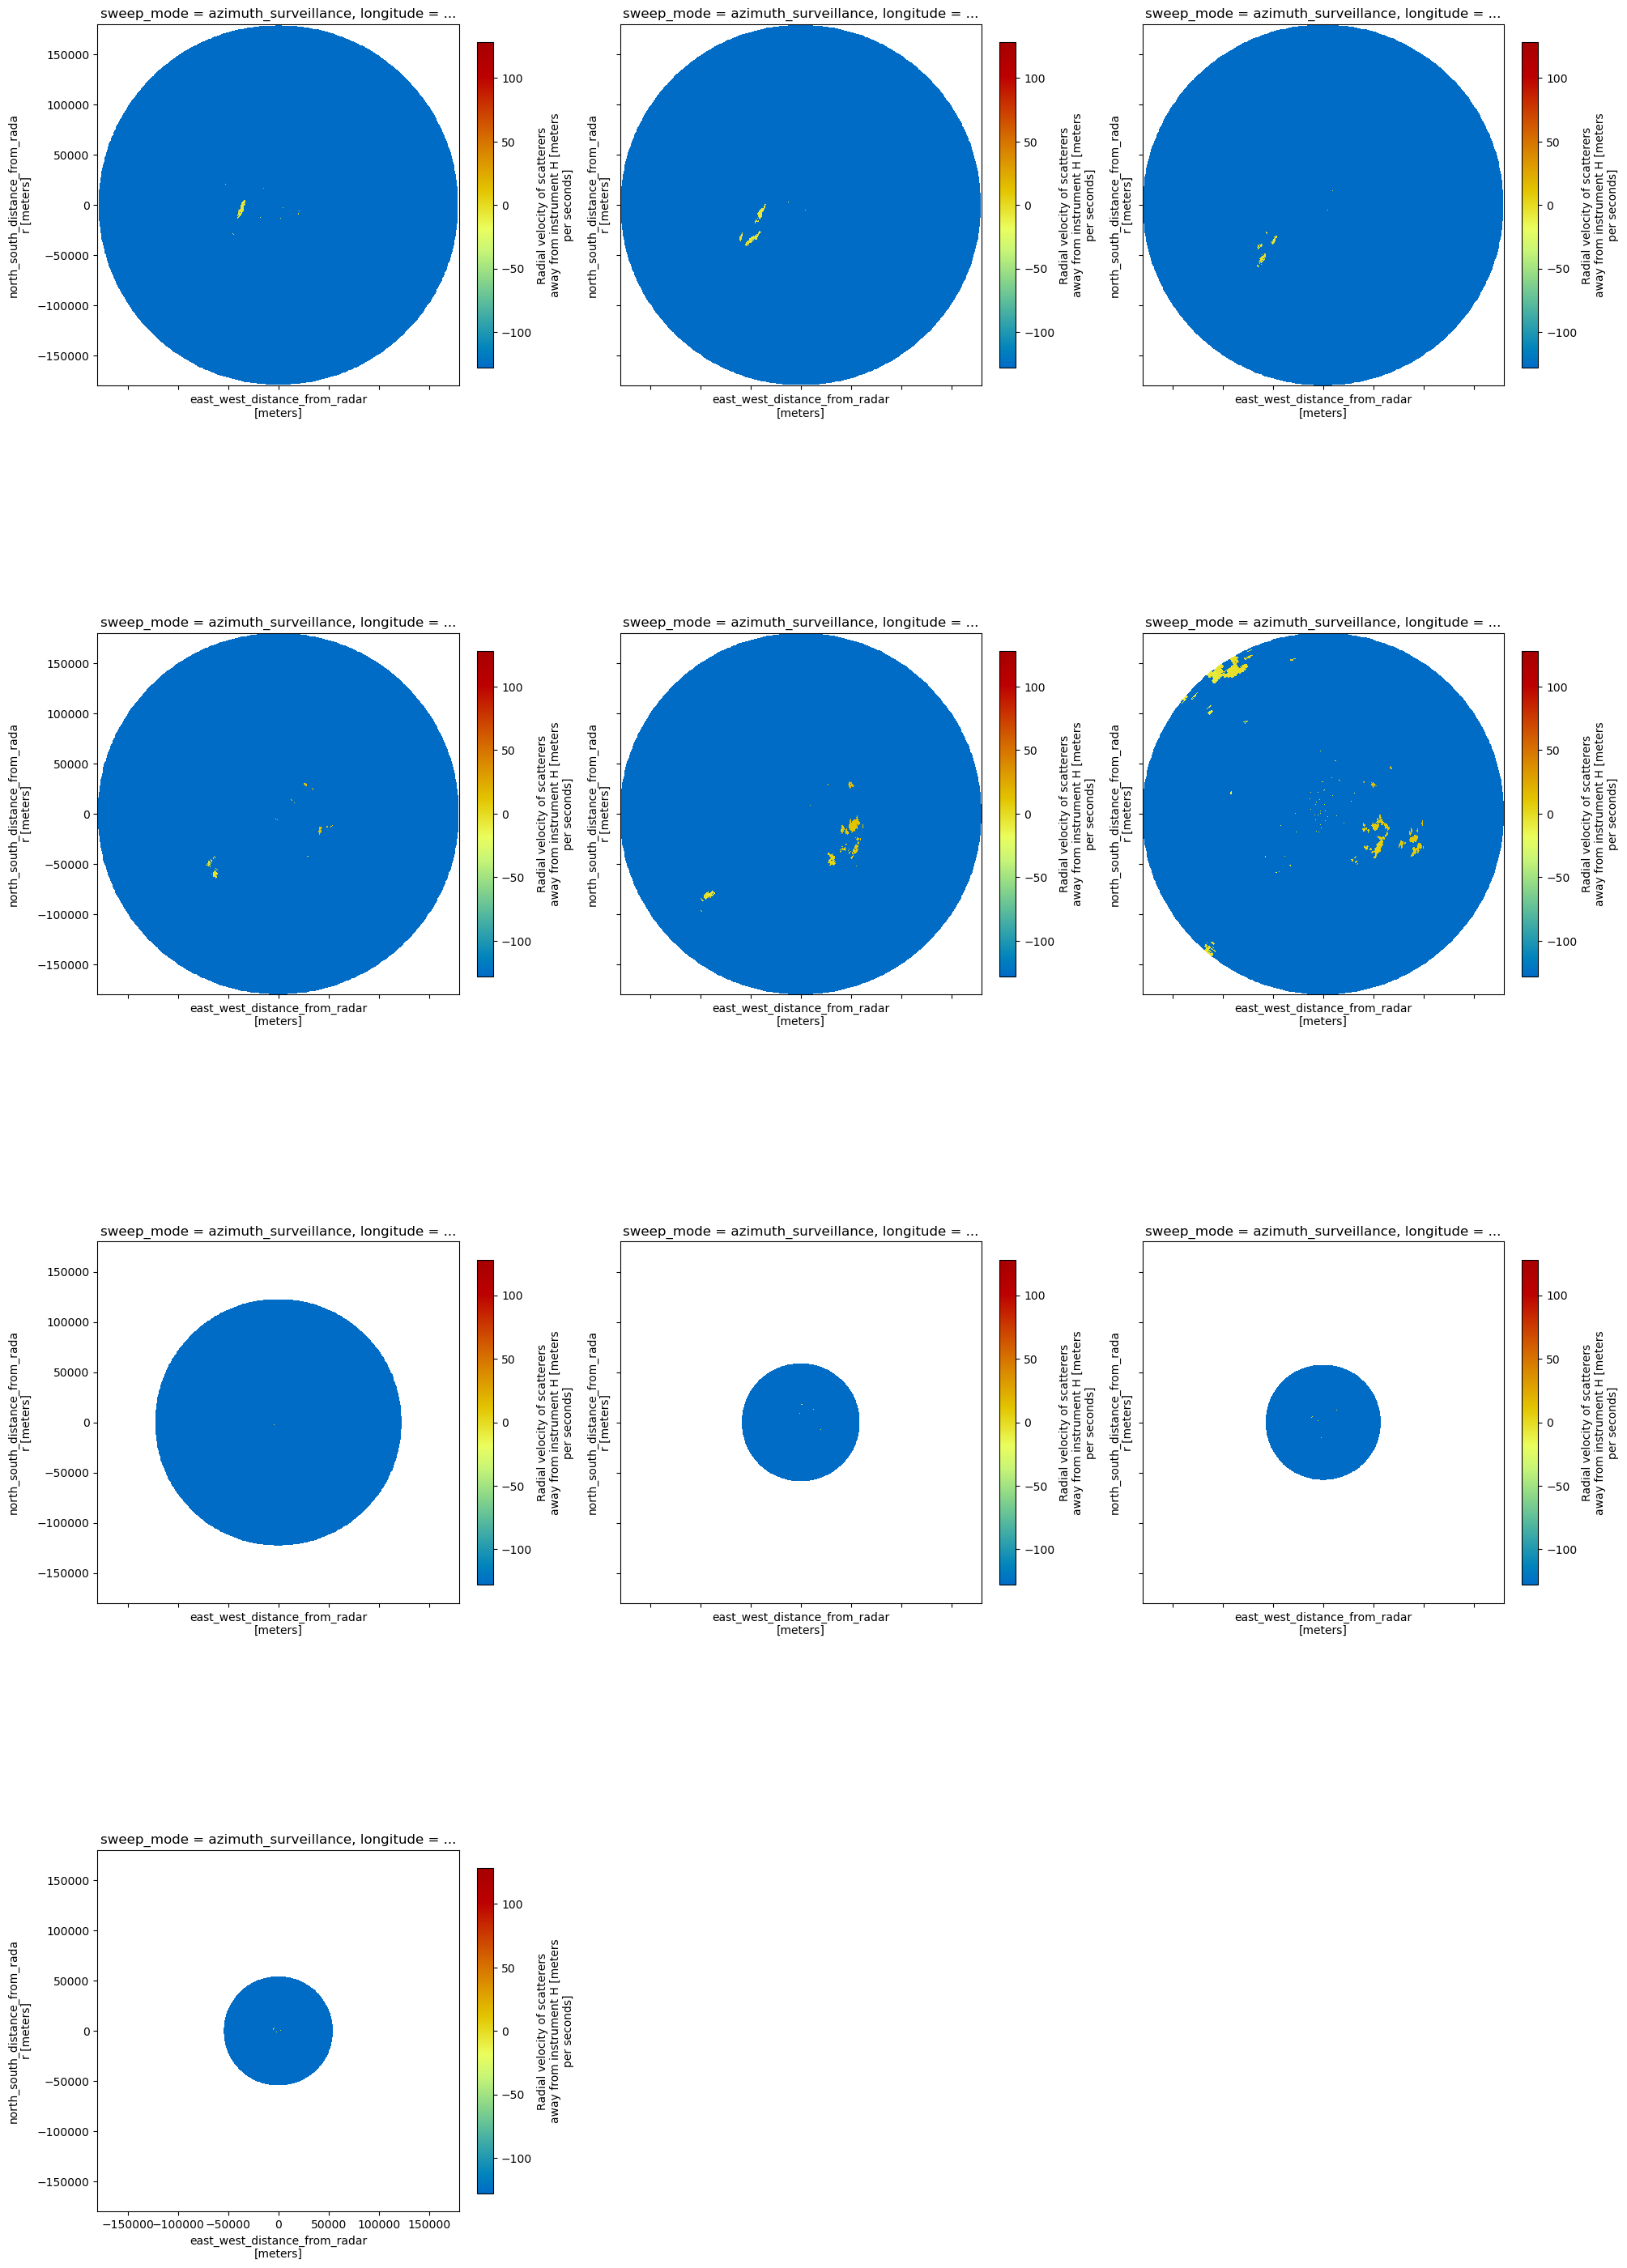

In [18]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.groups[1:]):
    swp = vol[grp].isel(volume_time=0).ds
    swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
    swp.VRADH.wrl.georef.georeference().wrl.vis.plot(ax=gs.flat[i], fig=fig)
    ax = plt.gca()
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### Plot single sweep using cartopy

In [19]:
vol0 = vol.isel(volume_time=0)
swp = vol0["sweep_9"].ds
# need to assign sweep_mode as coordinate
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)

In [20]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=6.967111 +lat_0=51.405649 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


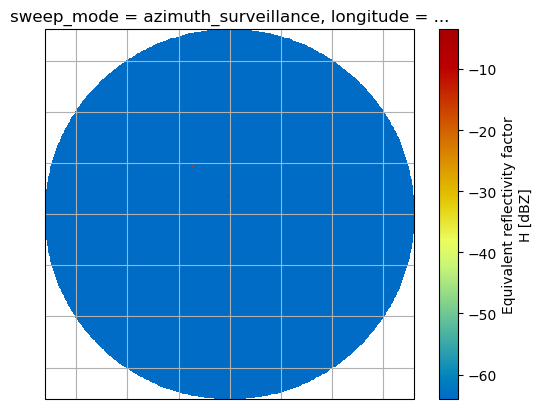

In [21]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)

pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(crs=map_proj)
ax = plt.gca()
ax.gridlines(crs=map_proj)
print(ax)

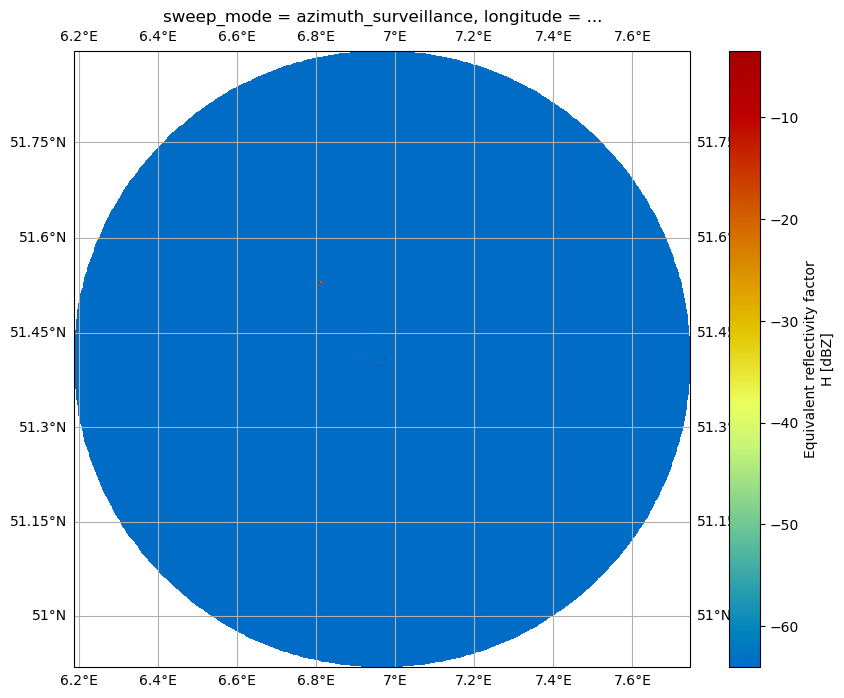

In [22]:
map_proj = ccrs.Mercator(central_longitude=vol0.root.ds.longitude.values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines(draw_labels=True)

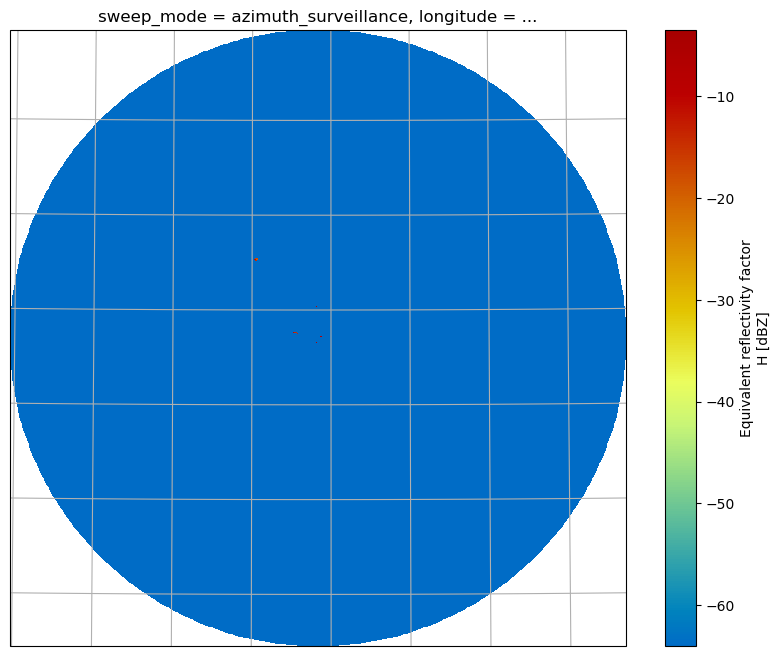

In [23]:
fig = plt.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray inherits dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [24]:
vol["sweep_9"].isel(volume_time=0).ds.DBZH

<xarray.DataArray 'DBZH' (azimuth: 360, range: 240)>
array([[-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293],
       [-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293],
       [-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293],
       ...,
       [-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293],
       [-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293],
       [-64.00293, -64.00293, -64.00293, ..., -64.00293, -64.00293,
        -64.00293]], dtype=float32)
Coordinates:
  * range      (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
  * azimuth    (azimuth) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    elevation  (azimuth) float64 24.98 24.98 24.98 24.98 ... 24.98 24.98 24.98
    time       (azimuth) datetime64[ns] 2023-11-03T14:13:54.572999936 ... 202...
    longitude  float64 6.967
    latitude   float64 51.41
    altitude   float64 185.1
Attributes:
    _Undetect:      0.0
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

In [25]:
vol["sweep_9"].isel(volume_time=0).ds.sweep_mode

<xarray.DataArray 'sweep_mode' ()>
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    longitude  float64 6.967
    latitude   float64 51.41
    altitude   float64 185.1

## Plot Quasi Vertical Profile

In [26]:
ts = vol["sweep_9"]
ts

DataTree('sweep_9', parent="root")
    Dimensions:            (range: 240, azimuth: 360, volume_time: 6)
    Coordinates:
      * range              (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
      * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 24.98 24.98 ... 24.99
        time               (volume_time, azimuth) datetime64[ns] 2023-11-03T14:13...
        longitude          float64 6.967
        latitude           float64 51.41
        altitude           float64 185.1
    Dimensions without coordinates: volume_time
    Data variables:
        DBZH               (volume_time, azimuth, range) float32 -64.0 ... -64.0
        sweep_mode         (volume_time) <U20 'azimuth_surveillance' ... 'azimuth...
        sweep_number       int64 9
        prt_mode           (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 25.0 25.0 25.0 25.0 25.0 25.0
        VRADH              (volume_time, azimuth, range) float32 -128.0 ... -128.0

(0.0, 20000.0)

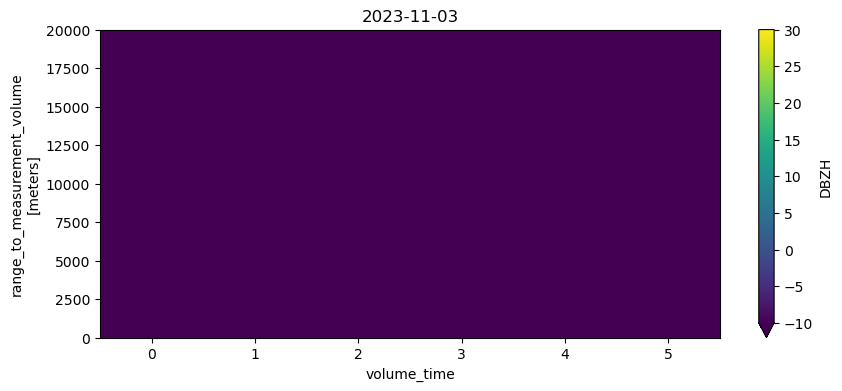

In [27]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ts.ds.DBZH.median("azimuth").plot(x="volume_time", vmin=-10, vmax=30, ax=ax)
ax.set_title(f"{np.datetime_as_string(ts.ds.time[0][0].values, unit='D')}")
ax.set_ylim(0, 20000)

## Export to OdimH5

This exports the radar volume at given timestep including all moments into one ODIM_H5 compliant data file.

In [28]:
xradar.io.to_odim(vol0, "dwd_odim.h5", source="RAD:DWD")

## Export to Cf/Radial2

This exports the radar volume at given timestep including all moments into one Cf/Radial2 compliant data file.

In [29]:
xradar.io.to_cfradial2(vol0, "dwd_cfradial2.nc")

## Import again


In [30]:
vol1 = xradar.io.open_odim_datatree("dwd_odim.h5")
display(vol1)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2023-11-03T14:11:44Z'
│       time_coverage_end    <U20 '2023-11-03T14:16:43Z'
│       longitude            float64 6.967
│       altitude             float64 185.1
│       latitude             float64 51.41
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2023-11-03T14:15:54.709691392...
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2023-11-03T14:16:17.134692096...
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2023-11-03T14:16:39.559693056...
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           VRADH              (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int64 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float32 ...
│           time               (azimuth) datetime64[ns] 2023-11-03T14:12:01.920805120...
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│         * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 3

In [31]:
vol2 = open_datatree("dwd_cfradial2.nc")
display(vol2)

DataTree('None', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 ...
│       platform_type        object ...
│       instrument_type      object ...
│       time_coverage_start  object ...
│       time_coverage_end    object ...
│       longitude            float64 ...
│       altitude             float64 ...
│       latitude             float64 ...
│   Attributes:
│       Conventions:      Cf/Radial
│       version:          2.0
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None: xradar v0.4.1 CfRadial2 export
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (range: 720, time: 360)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│         * time               (time) datetime64[ns] 2023-11-03T14:15:35.230000128 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
│           VRADH              (time, range) float32 ...
├── DataTree('sweep_1')
│       Dimensions:            (range: 720, time: 360)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│         * time               (time) datetime64[ns] 2023-11-03T14:15:58.295500032 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
│           VRADH              (time, range) float32 ...
├── DataTree('sweep_2')
│       Dimensions:            (range: 720, time: 360)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│         * time               (time) datetime64[ns] 2023-11-03T14:16:21.360000256 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
│           VRADH              (time, range) float32 ...
├── DataTree('sweep_3')
│       Dimensions:            (range: 720, time: 360)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│         * time               (time) datetime64[ns] 2023-11-03T14:11:44.483000064 .....
│       Data variables:
│           DBZH               (time, range) float32 ...
│           sweep_mode         object ...
│           sweep_number       int64 ...
│           prt_mode           object ...
│           follow_mode        object ...
│           sweep_fixed_angle  float64 ...
│           VRADH              (time, range) float32 ...
├── DataTree('sweep_4')
│       Dimensions:            (range: 720, time: 360)
│       Coordinates:
│         * range              (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 ...
│           elevation          (time) float64 ...
│         * time               (time) datetime64[ns]